Team Members:
Jetendra Mulinti, Goutham Vemula, Prajeeth Nakka

# Introduction:
We are creating 4 ML models (Decision Trees and Random forest) & pick one ML model which predicts the reg_pct_level.
Steps we are following

1. Loading data
2. Cleaning data
3. EDA
4. Feature selection
5. Train the model with 4 Models
6. Validating Metrics.
7. Selecting Models
8. Conclusion

In [41]:
### Import packages

import warnings
warnings.filterwarnings('ignore')
import pandas as pd
pd.options.display.max_columns = 999
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
import os
from datetime import datetime

### sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_error

###### Standardization of the variables
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

from statsmodels.stats.outliers_influence import variance_inflation_factor


#### Modelling
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import PoissonRegressor
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_poisson_deviance, mean_squared_error, r2_score
import statsmodels.api as sm
from statsmodels.formula.api import glm

from sklearn.metrics import mean_squared_error

# Data Loading

In [2]:
github_url = 'https://raw.githubusercontent.com/JetendraMulinti/DAV-6150---DataScience/main/M11%20Practical%20Challenge%20Decision%20Tree%20versus%20Random%20Forest%20Performance/M11_Data.csv'

NY_df = pd.read_csv(github_url)
NY_df.head(2)

report_school_year  aggregation_index aggregation_type  \
0            2018-19                  3         District   
1            2018-19                  3         District   

              aggregation_name  nrc_code                   nrc_desc  \
0  ALBANY CITY SCHOOL DISTRICT         3  Urban-Suburban High Needs   
1  ALBANY CITY SCHOOL DISTRICT         3  Urban-Suburban High Needs   

   county_code county_name  nyc_ind                     membership_desc  \
0            1      ALBANY        0  2013 Total Cohort - 6 Year Outcome   
1            1      ALBANY        0  2013 Total Cohort - 6 Year Outcome   

   subgroup_code subgroup_name enroll_cnt grad_cnt grad_pct reg_cnt reg_pct  \
0              1  All Students        658      464      71%     310     47%   
1              2        Female        324      246      76%     169     52%   

  dropout_cnt dropout_pct  
0         148         22%  
1          65         20%

# Data Cleaning

In [3]:
#### upon oberserving the data in excel we found some rows are having '-' so planning to remove them

print("No of rows with -'s instead of data: ",len(NY_df[NY_df['enroll_cnt'] == '-']))
print(" % of missing data: ",len(NY_df[NY_df['enroll_cnt'] == '-']) / len(NY_df) * 100)

##### removing that data
NY_df = NY_df[NY_df['enroll_cnt'] != '-'].reset_index(drop=True)

print("Post cleaning of data: ",len(NY_df))

No of rows with -'s instead of data:  33478
 % of missing data:  45.76498250218723
Post cleaning of data:  39674


In [4]:
print("Shape of the data: ", NY_df.shape)

Shape of the data:  (39674, 19)


In [5]:
NY_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39674 entries, 0 to 39673
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   report_school_year  39674 non-null  object
 1   aggregation_index   39674 non-null  int64 
 2   aggregation_type    39674 non-null  object
 3   aggregation_name    39674 non-null  object
 4   nrc_code            39674 non-null  int64 
 5   nrc_desc            39674 non-null  object
 6   county_code         39674 non-null  int64 
 7   county_name         39674 non-null  object
 8   nyc_ind             39674 non-null  int64 
 9   membership_desc     39674 non-null  object
 10  subgroup_code       39674 non-null  int64 
 11  subgroup_name       39674 non-null  object
 12  enroll_cnt          39674 non-null  object
 13  grad_cnt            39674 non-null  object
 14  grad_pct            39674 non-null  object
 15  reg_cnt             39674 non-null  object
 16  reg_pct             39

In [6]:
####### Converting Data Types as per data

def convert_column_data_types(df):

    # Convert 'cnt' columns to int and 'pct' columns to float before that remove % symbol
    for column in df.columns:
        if column.endswith('cnt'):
            df[column] = pd.to_numeric(df[column], errors='coerce').fillna(0).astype(int)
        elif column.endswith('pct'):
            df[column] = df[column].str.replace('%', '').astype(float)

    # Convert specific columns based on the suggested data types
    specific_columns = {
        'report_school_year': 'object',
        'aggregation_index': 'int64',
        'aggregation_type': 'object',
        'nrc_code': 'int64',
        'nrc_desc': 'object',
        'county_code': 'int64',
        'county_name': 'object',
        'nyc_ind': 'bool',
        'membership_desc': 'object',
        'subgroup_code': 'int64',
        'subgroup_name': 'object'
    }

    for column, dtype in specific_columns.items():
        if column in df.columns:
            if dtype == 'bool':
                df[column] = df[column].astype(bool)
            else:
                df[column] = df[column].astype(dtype)

    return df

In [7]:
### Calling functions to change the data types

NY_df =convert_column_data_types(NY_df)

NY_df.head(2)

report_school_year  aggregation_index aggregation_type  \
0            2018-19                  3         District   
1            2018-19                  3         District   

              aggregation_name  nrc_code                   nrc_desc  \
0  ALBANY CITY SCHOOL DISTRICT         3  Urban-Suburban High Needs   
1  ALBANY CITY SCHOOL DISTRICT         3  Urban-Suburban High Needs   

   county_code county_name  nyc_ind                     membership_desc  \
0            1      ALBANY    False  2013 Total Cohort - 6 Year Outcome   
1            1      ALBANY    False  2013 Total Cohort - 6 Year Outcome   

   subgroup_code subgroup_name  enroll_cnt  grad_cnt  grad_pct  reg_cnt  \
0              1  All Students         658       464      71.0      310   
1              2        Female         324       246      76.0      169   

   reg_pct  dropout_cnt  dropout_pct  
0     47.0          148         22.0  
1     52.0           65         20.0

In [8]:
NY_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39674 entries, 0 to 39673
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   report_school_year  39674 non-null  object 
 1   aggregation_index   39674 non-null  int64  
 2   aggregation_type    39674 non-null  object 
 3   aggregation_name    39674 non-null  object 
 4   nrc_code            39674 non-null  int64  
 5   nrc_desc            39674 non-null  object 
 6   county_code         39674 non-null  int64  
 7   county_name         39674 non-null  object 
 8   nyc_ind             39674 non-null  bool   
 9   membership_desc     39674 non-null  object 
 10  subgroup_code       39674 non-null  int64  
 11  subgroup_name       39674 non-null  object 
 12  enroll_cnt          39674 non-null  int64  
 13  grad_cnt            39674 non-null  int64  
 14  grad_pct            39674 non-null  float64
 15  reg_cnt             39674 non-null  int64  
 16  reg_

# EDA

In [9]:
## Sitation: Help from chatgpt
###### Creating a function that gives univariate analysis on quantitative columns


def Hist_BoxPlotFunction(df, pdf_filename):

    # Path for saving the PDF in the current working directory
    pdf_path = os.path.join(os.getcwd(), pdf_filename)

    quantitative_columns = df.select_dtypes(include=['float64', 'int64','int32']).columns

    with PdfPages(pdf_path) as pdf:
        for col in quantitative_columns:
            fig, axs = plt.subplots(1, 2, figsize=(12, 4))

            # Histogram
            sns.histplot(df[col], ax=axs[0], kde=True)
            axs[0].set_title(f'Histogram of {col}')

            # Box Plot
            sns.boxplot(x=df[col], ax=axs[1])
            axs[1].set_title(f'Box Plot of {col}')

            plt.tight_layout()
            pdf.savefig(fig)  # Save the figure into the PDF
            plt.show()  # Display the plot
            plt.close(fig)  # Close to free up memory

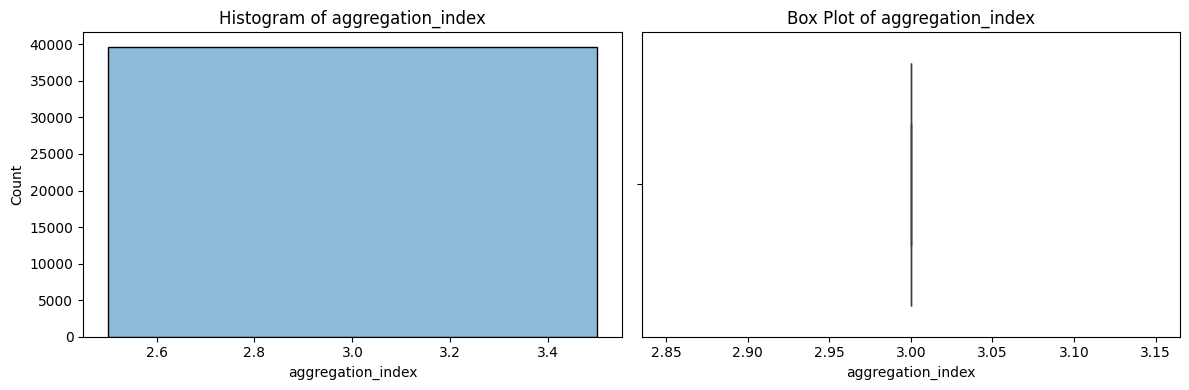

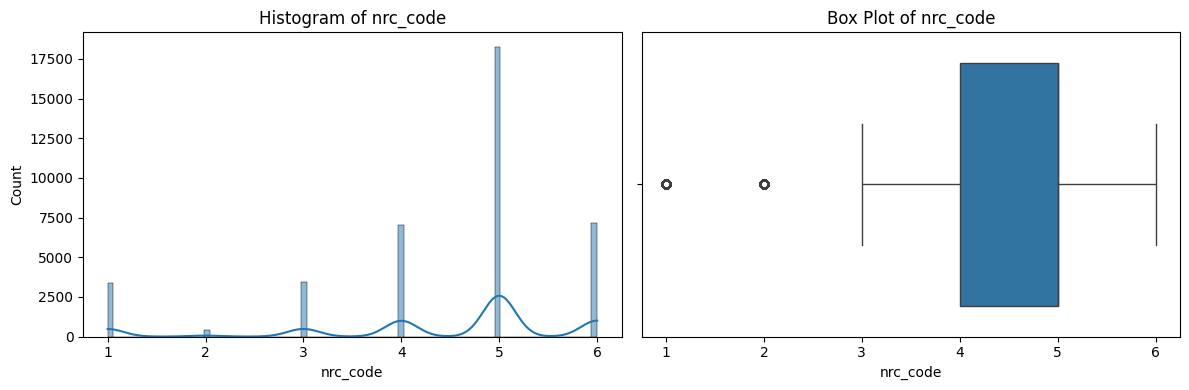

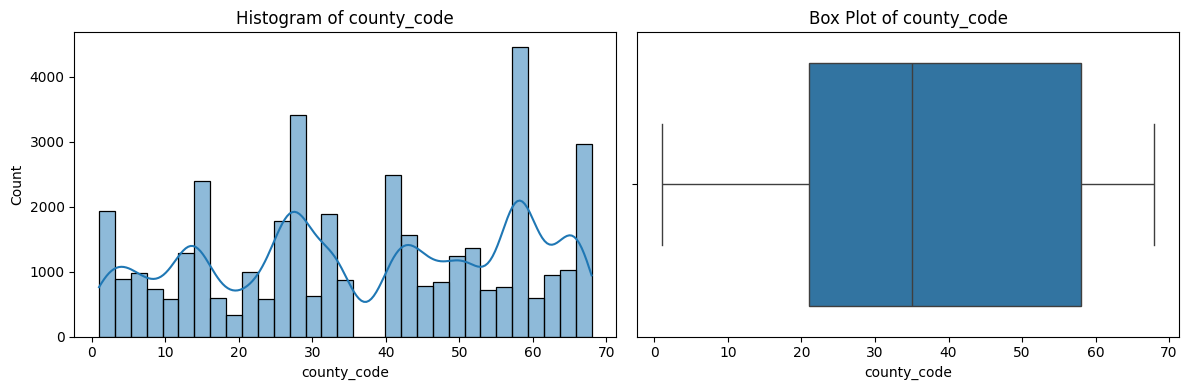

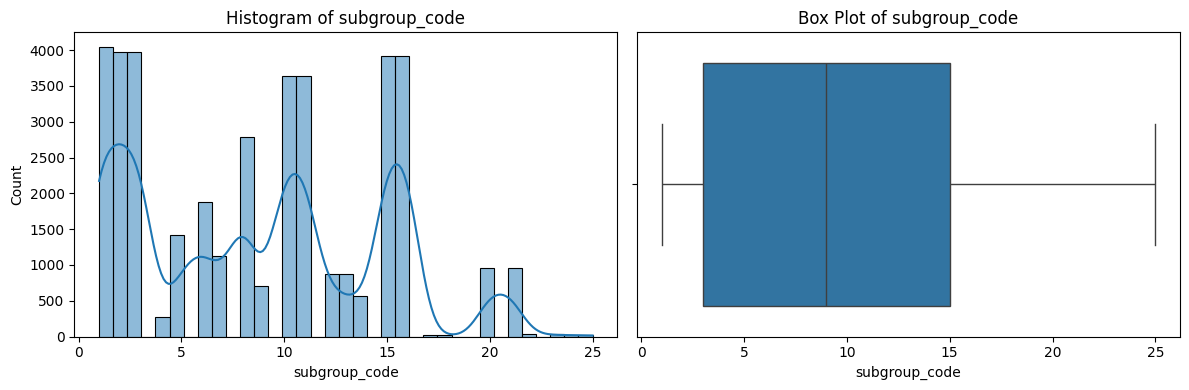

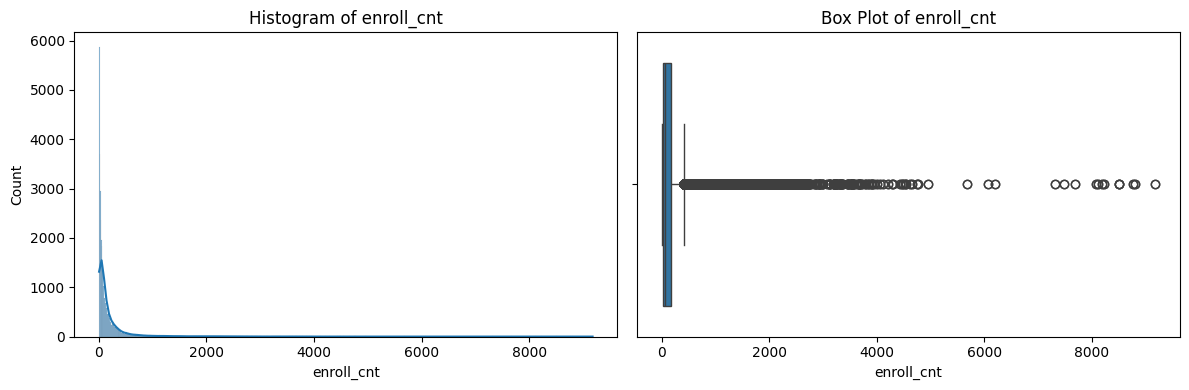

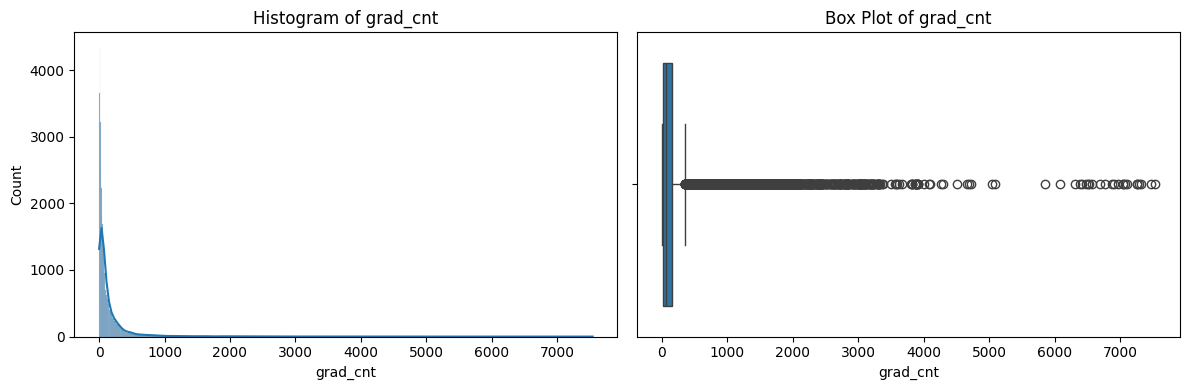

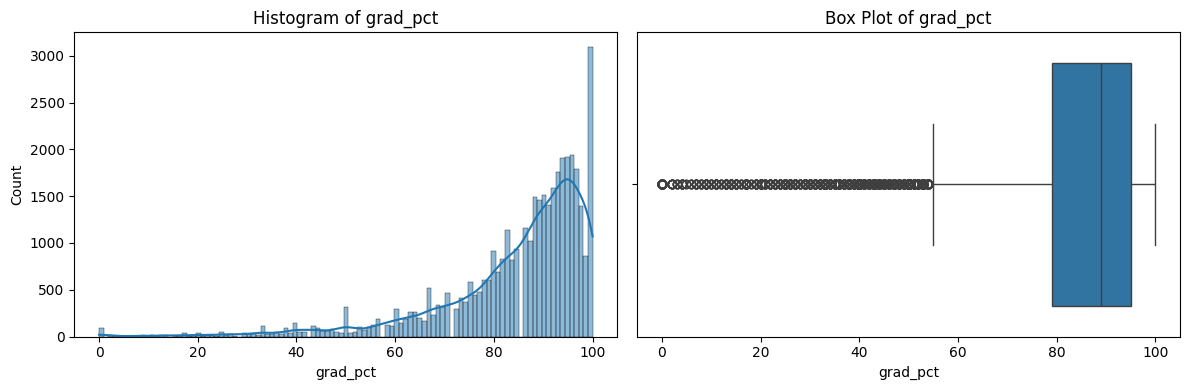

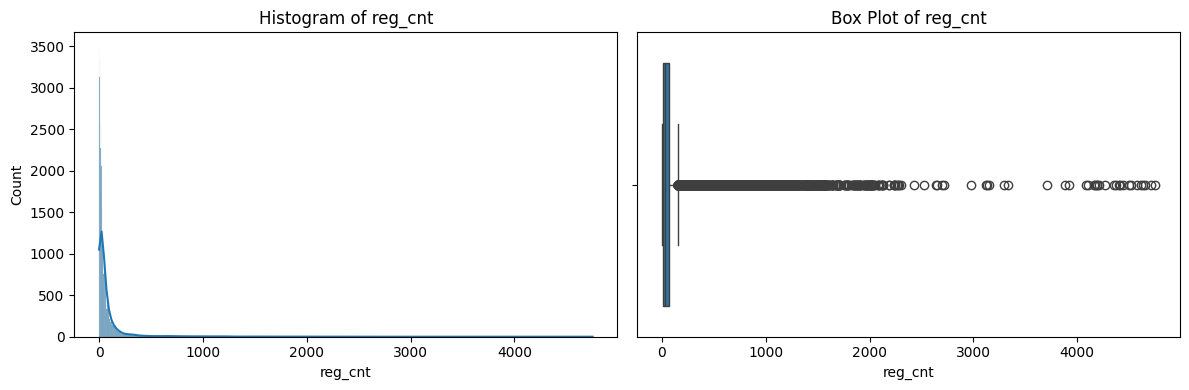

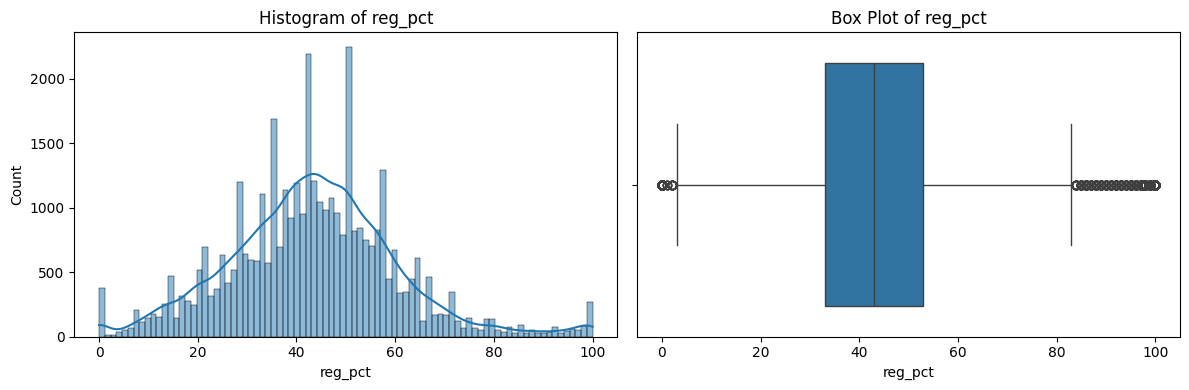

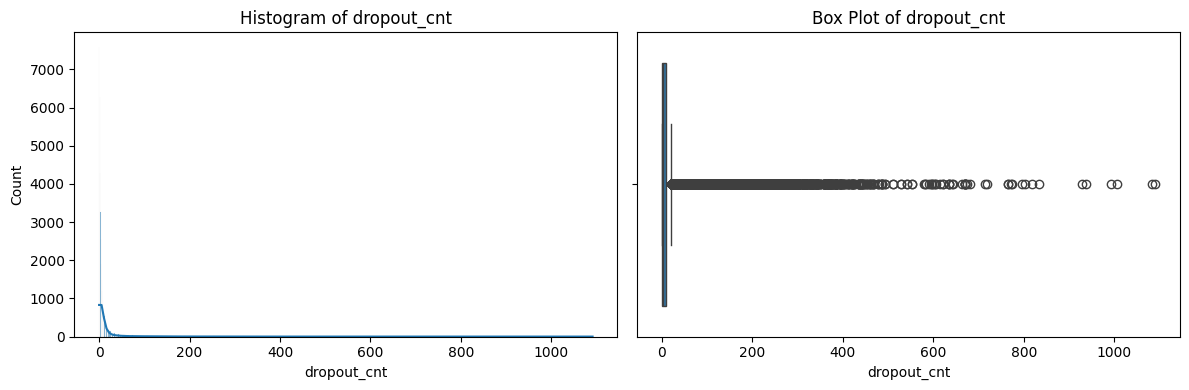

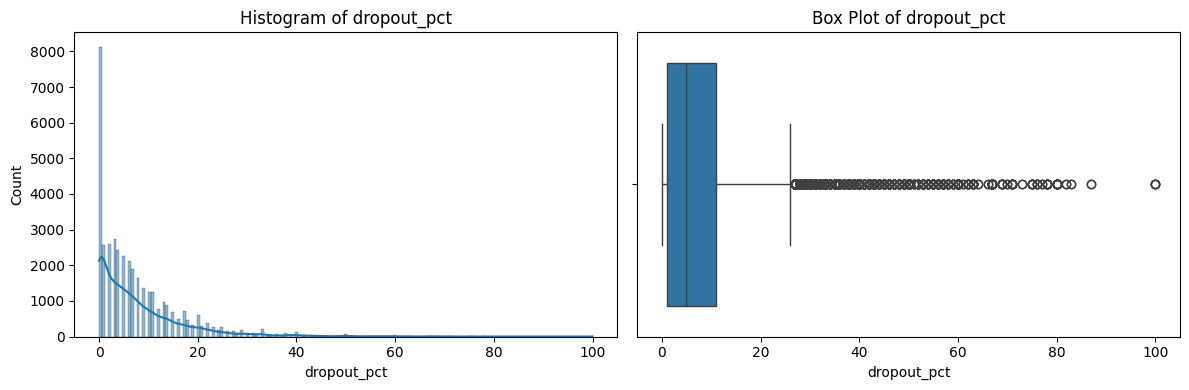

In [10]:
Hist_BoxPlotFunction(NY_df,'Quant_visuals.pdf')

# Observations
1. The nrc_code and county_code are well-distributed among different groups, with county_code exhibiting a wide spread, indicating a diverse set of counties. Subgroup_code shows variability in frequency, with certain subgroups being more common.

2. School performance indicators like grad_cnt, grad_pct, reg_cnt, and reg_pct are mostly concentrated at lower values but have a long tail towards higher values, suggesting that while most schools have lower graduation numbers or percentages, a few have notably higher outcomes.

3. Dropout_pct varies widely among schools, with the data showing both low and high dropout rates, and some outliers indicating exceptionally high dropout percentages.

In [11]:
#### Capping (For Notmally distributed data)
#### We considered lower_percentile, upper_percentile as default values.

def cap_outliers(series, lower_percentile=0.05, upper_percentile=0.95):
    """
    Caps outliers in a pandas series to specified percentile thresholds.
    """
    quantiles = series.quantile([lower_percentile, upper_percentile])
    series_capped = series.clip(quantiles[lower_percentile], quantiles[upper_percentile])
    return series_capped


CappingColumns = NY_df.select_dtypes(include=['float64', 'int64', 'int32']).columns.tolist()


# Applying the function to cap outliers in the dataset
for column in CappingColumns:
    NY_df[column] = cap_outliers(NY_df[column])

NY_df.head(2)

report_school_year  aggregation_index aggregation_type  \
0            2018-19                  3         District   
1            2018-19                  3         District   

              aggregation_name  nrc_code                   nrc_desc  \
0  ALBANY CITY SCHOOL DISTRICT         3  Urban-Suburban High Needs   
1  ALBANY CITY SCHOOL DISTRICT         3  Urban-Suburban High Needs   

   county_code county_name  nyc_ind                     membership_desc  \
0            4      ALBANY    False  2013 Total Cohort - 6 Year Outcome   
1            4      ALBANY    False  2013 Total Cohort - 6 Year Outcome   

   subgroup_code subgroup_name  enroll_cnt  grad_cnt  grad_pct  reg_cnt  \
0              1  All Students       658.0       464      71.0      310   
1              2        Female       324.0       246      76.0      169   

   reg_pct  dropout_cnt  dropout_pct  
0     47.0           80         22.0  
1     52.0           65         20.0

In [12]:
sum_df = pd.DataFrame(NY_df[['enroll_cnt','grad_cnt','reg_cnt','dropout_cnt']].sum(), columns=['sum']).reset_index()

sum_df = sum_df.sort_values(by='sum', ascending=False)
sum_df['Percent'] = round((sum_df['sum'] / sum_df[sum_df['index'] == 'enroll_cnt']['sum'].sum()) * 100)
sum_df

index        sum  Percent
0   enroll_cnt  5788558.4    100.0
1     grad_cnt  4963181.0     86.0
2      reg_cnt  2431473.0     42.0
3  dropout_cnt   422906.0      7.0

**Here we want to compare the dropouts & grad by category wise, so instead of using plots we are grouping by only for better understanding**

In [13]:
def calculate_percentages_and_sort(df, group_by_column, sort_by_column, ascending=False):

    temp_df = df.groupby(group_by_column)['enroll_cnt','grad_cnt','dropout_cnt',
                                        'reg_cnt'].sum().reset_index()
    ### This is column lvl Pct
    temp_df['enroll_pct col-lvl %'] = round((temp_df['enroll_cnt'] / temp_df['enroll_cnt'].sum()) * 100, 2)

    ### this is Row lvl Pct
    temp_df['grad_pct %'] = ((temp_df['grad_cnt'] / temp_df['enroll_cnt']) * 100).astype(int)
    temp_df['dropout_pct %'] = ((temp_df['dropout_cnt'] / temp_df['enroll_cnt']) * 100).astype(int)
    temp_df['reg_pct %'] = ((temp_df['reg_cnt'] / temp_df['enroll_cnt']) * 100).astype(int)

    ## ordering columns
    temp_df = temp_df[[group_by_column,'enroll_cnt','enroll_pct col-lvl %','grad_pct %','dropout_pct %',
                       'reg_pct %']]


    temp_df = temp_df.sort_values(by=[sort_by_column], ascending=ascending).reset_index(drop=True)
    return temp_df

In [14]:
### County_name wise (dropout_pct%)
calculate_percentages_and_sort(NY_df, group_by_column='county_name', sort_by_column='dropout_pct %', ascending=False)

county_name  enroll_cnt  enroll_pct col-lvl %  grad_pct %  dropout_pct %  \
0   MONTGOMERY     19480.0                  0.34          77             14   
1      CHEMUNG     25922.0                  0.45          77             14   
2       FULTON     18078.0                  0.31          79             13   
3        YATES      5792.0                  0.10          83             12   
4        BRONX    303195.0                  5.24          78             12   
..         ...         ...                   ...         ...            ...   
57     SUFFOLK    735685.1                 12.71          89              4   
58    HAMILTON       382.0                  0.01          91              3   
59     GENESEE     17216.0                  0.30          92              3   
60      NASSAU    577296.6                  9.97          90              3   
61      PUTNAM     40738.0                  0.70          93              2   

    reg_pct %  
0          45  
1          36  
2          47  
3          47  
4          44  
..        ...  
57         37  
58         50  
59         49  
60         31  
61         39  

[62 rows x 6 columns]

In [15]:
### County_name wise
calculate_percentages_and_sort(NY_df, group_by_column='county_name', sort_by_column='grad_pct %', ascending=False)

county_name  enroll_cnt  enroll_pct col-lvl %  grad_pct %  dropout_pct %  \
0        PUTNAM     40738.0                  0.70          93              2   
1       GENESEE     17216.0                  0.30          92              3   
2      SCHUYLER      4036.0                  0.07          92              4   
3       WYOMING      8444.0                  0.15          92              4   
4         ESSEX      6498.0                  0.11          91              5   
..          ...         ...                   ...         ...            ...   
57        KINGS    512429.1                  8.85          78             11   
58  SCHENECTADY     61174.9                  1.06          78              9   
59        BRONX    303195.0                  5.24          78             12   
60   MONTGOMERY     19480.0                  0.34          77             14   
61      CHEMUNG     25922.0                  0.45          77             14   

    reg_pct %  
0          39  
1          49  
2          57  
3          47  
4          47  
..        ...  
57         45  
58         41  
59         44  
60         45  
61         36  

[62 rows x 6 columns]

# **nrc_desc**

In [16]:
### nrc_desc wise (dropout_pct%)
calculate_percentages_and_sort(NY_df, group_by_column='nrc_desc', sort_by_column='dropout_pct %', ascending=False)

nrc_desc  enroll_cnt  enroll_pct col-lvl %  \
0              Urban-Suburban High Needs    632957.4                 10.93   
1  Buffalo  Rochester  Yonkers  Syracuse    194188.6                  3.35   
2                                    NYC   1519180.8                 26.24   
3                       Rural High Needs    343720.0                  5.94   
4                          Average Needs   2070142.9                 35.76   
5                              Low Needs   1028368.7                 17.77   

   grad_pct %  dropout_pct %  reg_pct %  
0          75             12         48  
1          78             11         44  
2          79             11         45  
3          85              9         47  
4          89              4         40  
5          94              1         34

In [17]:
### nrc_desc wise (grad_pct%)
calculate_percentages_and_sort(NY_df, group_by_column='nrc_desc', sort_by_column='grad_pct %', ascending=False)

nrc_desc  enroll_cnt  enroll_pct col-lvl %  \
0                              Low Needs   1028368.7                 17.77   
1                          Average Needs   2070142.9                 35.76   
2                       Rural High Needs    343720.0                  5.94   
3                                    NYC   1519180.8                 26.24   
4  Buffalo  Rochester  Yonkers  Syracuse    194188.6                  3.35   
5              Urban-Suburban High Needs    632957.4                 10.93   

   grad_pct %  dropout_pct %  reg_pct %  
0          94              1         34  
1          89              4         40  
2          85              9         47  
3          79             11         45  
4          78             11         44  
5          75             12         48

# **subgroup_name**

In [18]:
### subgroup_name wise (dropout_pct%)
calculate_percentages_and_sort(NY_df, group_by_column='subgroup_name', sort_by_column='dropout_pct %', ascending=False)

subgroup_name  enroll_cnt  enroll_pct col-lvl %  \
0                             Migrant       126.0                  0.00   
1            English Language Learner     61496.0                  1.06   
2                            Homeless     41960.0                  0.72   
3                      In Foster Care       296.0                  0.01   
4       American Indian/Alaska Native      5768.0                  0.10   
5          Students with Disabilities    186496.2                  3.22   
6                            Hispanic    215182.6                  3.72   
7                               Black    174785.1                  3.02   
8          Economically Disadvantaged    408455.2                  7.06   
9          Parent Not in Armed Forces      4510.0                  0.08   
10                        Not Migrant      5617.4                  0.10   
11                 Not in Foster Care     18706.2                  0.32   
12                        Multiracial     11646.0                  0.20   
13                       Not Homeless    423867.2                  7.32   
14                               Male    517640.0                  8.94   
15       Not English Language Learner    409669.9                  7.08   
16                       All Students    863223.8                 14.91   
17                             Female    493665.1                  8.53   
18         General Education Students    755259.4                 13.05   
19             Asian/Pacific Islander     93097.3                  1.61   
20     Not Economically Disadvantaged    560175.0                  9.68   
21  Formerly English Language Learner     32256.0                  0.56   
22                              White    503518.0                  8.70   
23             Parent in Armed Forces      1142.0                  0.02   

    grad_pct %  dropout_pct %  reg_pct %  
0           71             30         33  
1           39             27         24  
2           62             21         44  
3           66             20         33  
4           72             15         48  
5           63             12         31  
6           80             11         47  
7           79             10         50  
8           82             10         47  
9           83             10         40  
10          83             10         44  
11          83              9         44  
12          83              8         50  
13          84              8         44  
14          85              7         43  
15          86              6         43  
16          87              6         41  
17          89              6         41  
18          90              5         42  
19          88              5         36  
20          90              4         37  
21          89              4         65  
22          90              4         38  
23          95              2         57

In [19]:
### subgroup_name wise (grad_pct%)
calculate_percentages_and_sort(NY_df, group_by_column='subgroup_name', sort_by_column='grad_pct %', ascending=False)

subgroup_name  enroll_cnt  enroll_pct col-lvl %  \
0              Parent in Armed Forces      1142.0                  0.02   
1                               White    503518.0                  8.70   
2      Not Economically Disadvantaged    560175.0                  9.68   
3          General Education Students    755259.4                 13.05   
4   Formerly English Language Learner     32256.0                  0.56   
5                              Female    493665.1                  8.53   
6              Asian/Pacific Islander     93097.3                  1.61   
7                        All Students    863223.8                 14.91   
8        Not English Language Learner    409669.9                  7.08   
9                                Male    517640.0                  8.94   
10                       Not Homeless    423867.2                  7.32   
11                        Multiracial     11646.0                  0.20   
12                        Not Migrant      5617.4                  0.10   
13                 Not in Foster Care     18706.2                  0.32   
14         Parent Not in Armed Forces      4510.0                  0.08   
15         Economically Disadvantaged    408455.2                  7.06   
16                           Hispanic    215182.6                  3.72   
17                              Black    174785.1                  3.02   
18      American Indian/Alaska Native      5768.0                  0.10   
19                            Migrant       126.0                  0.00   
20                     In Foster Care       296.0                  0.01   
21         Students with Disabilities    186496.2                  3.22   
22                           Homeless     41960.0                  0.72   
23           English Language Learner     61496.0                  1.06   

    grad_pct %  dropout_pct %  reg_pct %  
0           95              2         57  
1           90              4         38  
2           90              4         37  
3           90              5         42  
4           89              4         65  
5           89              6         41  
6           88              5         36  
7           87              6         41  
8           86              6         43  
9           85              7         43  
10          84              8         44  
11          83              8         50  
12          83             10         44  
13          83              9         44  
14          83             10         40  
15          82             10         47  
16          80             11         47  
17          79             10         50  
18          72             15         48  
19          71             30         33  
20          66             20         33  
21          63             12         31  
22          62             21         44  
23          39             27         24

# **aggregation_name**

In [20]:
### aggregation_name wise (dropout_pct%)
calculate_percentages_and_sort(NY_df, group_by_column='aggregation_name', sort_by_column='dropout_pct %', ascending=False)

aggregation_name  enroll_cnt  \
0         GREENBURGH ELEVEN UNION FREE SCHOOL DISTRICT        72.0   
1    GEORGE JUNIOR REPUBLIC UNION FREE SCHOOL DISTRICT       104.0   
2                    POUGHKEEPSIE CITY SCHOOL DISTRICT     13052.0   
3       KIRYAS JOEL VILLAGE UNION FREE SCHOOL DISTRICT        32.0   
4                 ROOSEVELT UNION FREE SCHOOL DISTRICT     10986.0   
..                                                 ...         ...   
672                      KEENE CENTRAL SCHOOL DISTRICT       168.0   
673              THREE VILLAGE CENTRAL SCHOOL DISTRICT     19286.0   
674                  LANCASTER CENTRAL SCHOOL DISTRICT     14716.0   
675                    SYOSSET CENTRAL SCHOOL DISTRICT     16992.0   
676                   YORKTOWN CENTRAL SCHOOL DISTRICT      9336.0   

     enroll_pct col-lvl %  grad_pct %  dropout_pct %  reg_pct %  
0                    0.00          55             47         22  
1                    0.00          59             42         23  
2                    0.23          59             26         42  
3                    0.00          62             25         25  
4                    0.19          71             21         53  
..                    ...         ...            ...        ...  
672                  0.00          98              0         29  
673                  0.33          97              0         26  
674                  0.25          96              0         37  
675                  0.29          97              0         13  
676                  0.16          97              0         38  

[677 rows x 6 columns]

In [21]:
### aggregation_name wise (grad_pct%)
calculate_percentages_and_sort(NY_df, group_by_column='aggregation_name', sort_by_column='grad_pct %', ascending=False)

aggregation_name  enroll_cnt  \
0           BLIND BROOK-RYE UNION FREE SCHOOL DISTRICT      2952.0   
1                 SCARSDALE UNION FREE SCHOOL DISTRICT      9302.0   
2                 MANHASSET UNION FREE SCHOOL DISTRICT      9166.0   
3                       CLYMER CENTRAL SCHOOL DISTRICT       666.0   
4                  BYRAM HILLS CENTRAL SCHOOL DISTRICT      6322.0   
..                                                 ...         ...   
672       GREENBURGH-GRAHAM UNION FREE SCHOOL DISTRICT        86.0   
673       GREENBURGH ELEVEN UNION FREE SCHOOL DISTRICT        72.0   
674              NEW YORK CITY GEOGRAPHIC DISTRICT #23     25092.0   
675               HEMPSTEAD UNION FREE SCHOOL DISTRICT     24084.0   
676  MOUNT PLEASANT-COTTAGE UNION FREE SCHOOL DISTRICT       452.0   

     enroll_pct col-lvl %  grad_pct %  dropout_pct %  reg_pct %  
0                    0.05          99              0         98  
1                    0.16          99              0         95  
2                    0.16          99              0         12  
3                    0.01          99              0         30  
4                    0.11          99              0         98  
..                    ...         ...            ...        ...  
672                  0.00          58              4         23  
673                  0.00          55             47         22  
674                  0.43          53             17         40  
675                  0.42          51             14         37  
676                  0.01          33             20         13  

[677 rows x 6 columns]

# **nyc_ind**

In [22]:
### nyc_ind wise (dropout_pct%)
calculate_percentages_and_sort(NY_df, group_by_column='nyc_ind', sort_by_column='dropout_pct %', ascending=False)

nyc_ind  enroll_cnt  enroll_pct col-lvl %  grad_pct %  dropout_pct %  \
0     True   1519180.8                 26.24          79             11   
1    False   4269377.6                 73.76          87              5   

   reg_pct %  
0         45  
1         40

In [23]:
### nyc_ind wise (grad_pct%)
calculate_percentages_and_sort(NY_df, group_by_column='nyc_ind', sort_by_column='grad_pct %', ascending=False)

nyc_ind  enroll_cnt  enroll_pct col-lvl %  grad_pct %  dropout_pct %  \
0    False   4269377.6                 73.76          87              5   
1     True   1519180.8                 26.24          79             11   

   reg_pct %  
0         40  
1         45

1. Enrollment and Performance: Higher enrollment numbers in counties don’t necessarily translate to higher graduation rates, suggesting factors other than size impact performance.

2. Diverse Educational Outcomes: There's notable variation in graduation and dropout rates across different counties and school districts, indicating diverse educational outcomes.

3. Subgroup Disparities: Different subgroups of students exhibit varying graduation rates, highlighting potential disparities that may be influenced by socioeconomic or educational support factors.

4. Urban vs. Rural: The data hints at differences in performance between urban areas (like NYC) and other regions, which could be linked to resource availability or policy impacts.

5. Resource Levels: The percentage of enrollment at different educational levels may influence graduation rates, pointing to the importance of resource allocation and access to advanced education opportunities.

 # Data Preparation

 **Creating new categorical variable (reg_pct_level)**

In [24]:
# Calculate the median of 'reg_pct' to use as a threshold for categorization
median_reg_pct = NY_df['reg_pct'].median()

# Define a function to categorize 'reg_pct' into 'low', 'medium', 'high'
def categorize_reg_pct(reg_pct):
    if pd.isnull(reg_pct):
        return None  # Handle missing values explicitly if needed
    elif reg_pct < 0.5 * median_reg_pct:
        return 'low'
    elif reg_pct <= 1.5 * median_reg_pct:
        return 'medium'
    else:
        return 'high'

# Apply the function to create the 'reg_pct_level' column
NY_df['reg_pct_level'] = NY_df['reg_pct'].apply(categorize_reg_pct)

# Remove the 'reg_pct' and 'reg_cnt' columns to avoid collinearity
## NY_df = NY_df.drop(columns=['reg_pct', 'reg_cnt'])

# Display the distribution of the newly created 'reg_pct_level' variable
reg_pct_level_distribution = NY_df['reg_pct_level'].value_counts(normalize=True) * 100

reg_pct_level_distribution


medium    81.307657
low        9.867924
high       8.824419
Name: reg_pct_level, dtype: float64

# Prepped Data Review

In [25]:
### reg_pct_level wise (grad_pct%)
calculate_percentages_and_sort(NY_df, group_by_column='reg_pct_level', sort_by_column='grad_pct %', ascending=False)

reg_pct_level  enroll_cnt  enroll_pct col-lvl %  grad_pct %  dropout_pct %  \
0          high   346410.95                  5.98          90              5   
1           low   440608.10                  7.61          85              4   
2        medium  5001539.35                 86.40          85              7   

   reg_pct %  
0         68  
1         16  
2         42

In [26]:
### reg_pct_level wise (dropout_pct%)
calculate_percentages_and_sort(NY_df, group_by_column='reg_pct_level', sort_by_column='dropout_pct %', ascending=False)

reg_pct_level  enroll_cnt  enroll_pct col-lvl %  grad_pct %  dropout_pct %  \
0        medium  5001539.35                 86.40          85              7   
1          high   346410.95                  5.98          90              5   
2           low   440608.10                  7.61          85              4   

   reg_pct %  
0         42  
1         68  
2         16

1. High Achievers: Students in the 'high' regent percentage level have the highest graduation rate (90%) and a relatively low dropout rate (5%).

2. Struggling Students: Those in the 'low' regent percentage level have a lower graduation rate (85%) and slightly higher dropout rates (4%).

# **Feature selection**

In [30]:
####### I am using correlation matrix for identifying independent columns to dependent columns

def plot_custom_correlation_matrix(df, columns, response_variable=None):

    # Copy the dataframe to avoid modifying the original
    df_copy = df.copy()


    # For the purpose of correlation analysis, we need to convert categorical and count variables to numeric
    df_copy['enroll_cnt'] = pd.to_numeric(df_copy['enroll_cnt'], errors='coerce')
    df_copy['grad_cnt'] = pd.to_numeric(df_copy['grad_cnt'], errors='coerce')
    df_copy['dropout_cnt'] = pd.to_numeric(df_copy['dropout_cnt'], errors='coerce')


    # If a response variable is specified, encode it
    if response_variable and response_variable in df.columns:
        df_copy[response_variable + '_encoded'] = df[response_variable].map({'low': 0, 'medium': 1, 'high': 2})
        columns.append(response_variable + '_encoded')

    # Select the desired columns
    selected_df = df_copy[columns]

    # Calculate the correlation matrix
    corr_matrix = selected_df.corr()

    # Plotting
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
    plt.title('Custom Correlation Matrix')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.show()


**Here we are removing Percentage columns as it is similar to count column**

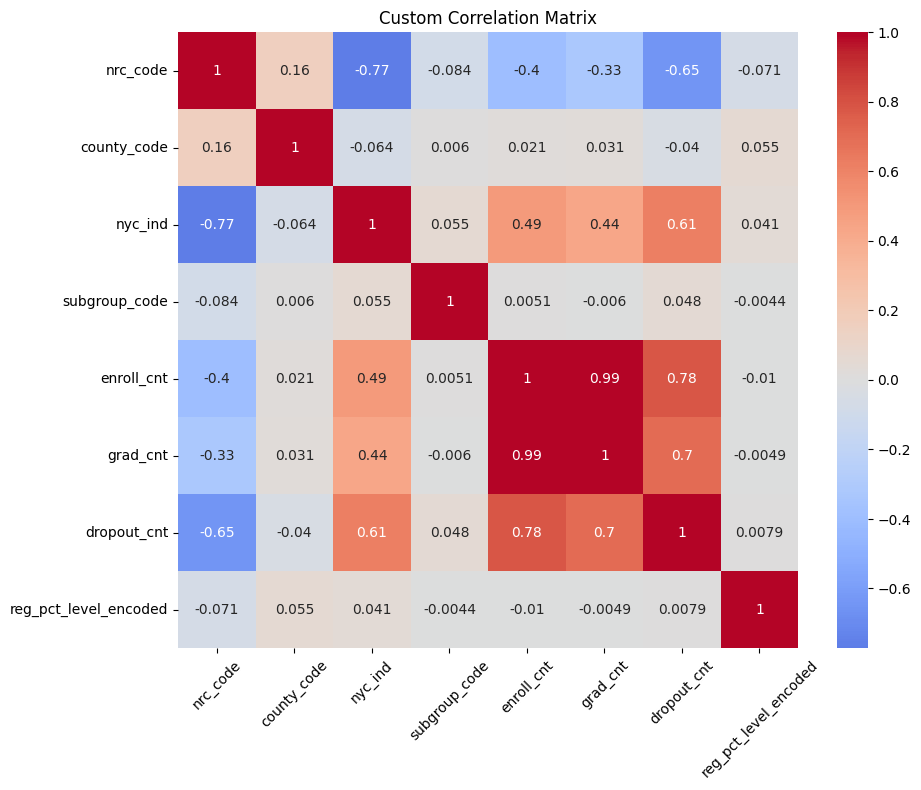

In [31]:

# Specifying the columns for analysis
columns_to_analyze = ['nrc_code', 'county_code', "nyc_ind", 'subgroup_code', 'enroll_cnt', 'grad_cnt', 'dropout_cnt']

# Plotting the correlation matrix including the response variable
plot_custom_correlation_matrix(NY_df, columns_to_analyze, 'reg_pct_level')


selecting 2 different sets of columns

set1 = ['nrc_code', 'nyc_ind', 'dropout_cnt', 'enroll_cnt']

set2 = ['nyc_ind', 'dropout_cnt', 'subgroup_code', 'county_code']

# **Decision Tree + Random Forest Modeling**

In [47]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

# Assuming NY_df is your DataFrame and 'reg_pct_level' is the name of your target variable
target = 'reg_pct_level'

# Feature Sets
set1 = ['nrc_code', 'nyc_ind', 'dropout_cnt', 'enroll_cnt']
set2 = ['nyc_ind', 'dropout_cnt', 'subgroup_code', 'county_code']

# Splitting data for set1 and set2
X_train_set1, X_test_set1, y_train_set1, y_test_set1 = train_test_split(NY_df[set1], NY_df[target], test_size=0.2, random_state=42)
X_train_set2, X_test_set2, y_train_set2, y_test_set2 = train_test_split(NY_df[set2], NY_df[target], test_size=0.2, random_state=42)

# Scaling data for set1
scaler_set1 = StandardScaler()
X_train_set1_scaled = scaler_set1.fit_transform(X_train_set1)
X_test_set1_scaled = scaler_set1.transform(X_test_set1)

# Scaling data for set2
scaler_set2 = StandardScaler()
X_train_set2_scaled = scaler_set2.fit_transform(X_train_set2)
X_test_set2_scaled = scaler_set2.transform(X_test_set2)

# Decision Tree model for set1
dt_set1 = DecisionTreeClassifier(random_state=42)
dt_set1.fit(X_train_set1_scaled, y_train_set1)

# Random Forest model for set1
rf_set1 = RandomForestClassifier(random_state=42)
rf_set1.fit(X_train_set1_scaled, y_train_set1)

# Decision Tree model for set2
dt_set2 = DecisionTreeClassifier(random_state=42)
dt_set2.fit(X_train_set2_scaled, y_train_set2)

# Random Forest model for set2
rf_set2 = RandomForestClassifier(random_state=42)
rf_set2.fit(X_train_set2_scaled, y_train_set2)


RandomForestClassifier(random_state=42)

# **Model Selection**

In [56]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, accuracy_score

# Function to perform cross-validation and calculate metrics
def evaluate_model(estimator, X_train, y_train, X_test, y_test, name):
    # Cross-validation to evaluate model performance on training data
    cv_scores = cross_val_score(estimator, X_train, y_train, cv=5, scoring='roc_auc_ovr')

    # Training the model on the entire training data
    estimator.fit(X_train, y_train)

    # Predictions on test set
    y_pred = estimator.predict(X_test)
    y_pred_proba = estimator.predict_proba(X_test)

    # Metrics
    accuracy = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovo')
    report = classification_report(y_test, y_pred)

    # Printing the results
    print(f"Model: {name}")
    print(f"Cross-Validated AUC: {np.mean(cv_scores)}")
    print(f"Test AUC: {auc}")
    print(f"Test Accuracy: {accuracy}")
    print(report)
    print(confusion_matrix(y_test, y_pred))
    print("-" * 60)

    return np.mean(cv_scores), auc, accuracy

# Evaluate each model
dt_set1_scores = evaluate_model(dt_set1, X_train_set1_scaled, y_train_set1, X_test_set1_scaled, y_test_set1, 'Decision Tree Set 1')
rf_set1_scores = evaluate_model(rf_set1, X_train_set1_scaled, y_train_set1, X_test_set1_scaled, y_test_set1, 'Random Forest Set 1')
dt_set2_scores = evaluate_model(dt_set2, X_train_set2_scaled, y_train_set2, X_test_set2_scaled, y_test_set2, 'Decision Tree Set 2')
rf_set2_scores = evaluate_model(rf_set2, X_train_set2_scaled, y_train_set2, X_test_set2_scaled, y_test_set2, 'Random Forest Set 2')

# Now we consider not only AUC but also accuracy and the preference for simpler models
# Assuming simpler models are preferred if performance is close
best_model, best_score = None, 0
for model, scores in zip(['dt_set1', 'rf_set1', 'dt_set2', 'rf_set2'], [dt_set1_scores, rf_set1_scores, dt_set2_scores, rf_set2_scores]):
    # If the performance is close to the best score, prefer the simpler model
    if scores[1] > best_score or (scores[1] == best_score and 'Decision Tree' in model):
        best_model, best_score = model, scores[1]


print('\n')
print(f"The preferred model is: {best_model} with AUC: {best_score}")


Model: Decision Tree Set 1
Cross-Validated AUC: 0.8284748852275797
Test AUC: 0.8453842147612528
Test Accuracy: 0.8344045368620038
              precision    recall  f1-score   support

        high       0.48      0.23      0.31       699
         low       0.58      0.39      0.47       759
      medium       0.87      0.95      0.91      6477

    accuracy                           0.83      7935
   macro avg       0.64      0.52      0.56      7935
weighted avg       0.81      0.83      0.81      7935

[[ 160   34  505]
 [  42  295  422]
 [ 133  178 6166]]
------------------------------------------------------------
Model: Random Forest Set 1
Cross-Validated AUC: 0.8451833589708826
Test AUC: 0.8460139833778877
Test Accuracy: 0.8402016383112791
              precision    recall  f1-score   support

        high       0.54      0.21      0.30       699
         low       0.61      0.38      0.47       759
      medium       0.87      0.96      0.91      6477

    accuracy             

# **Conclusion**

Our Random Forest model excelled in predicting the target variable, showing promise for practical use with its high accuracy and robust performance on new data.